In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import requests
import json
import time
from datetime import datetime

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
def btc():
    url = "https://www.bitstamp.net/api/v2/ohlc/btcusd/"
    timeframe = 86400
    start_date = 1312174800
    end_date = int(time.time())

    # set the maximum number of data points to return per request
    limit = 1000

    data_list = []
    while start_date <= end_date:

        request_end_date = min(start_date + limit*timeframe, end_date)
        response = requests.get(url + "?step=" + str(timeframe) + "&start=" + str(start_date) + "&end=" + str(request_end_date) + "&limit=" + str(limit))
        data = json.loads(response.text)
        data_list += data['data']['ohlc']
        start_date += limit*timeframe

    df = pd.DataFrame(data_list)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

    df.set_index('timestamp',drop=True, inplace = True)
    df.columns = [e.capitalize() for e in df.columns]
    df.sort_index(ascending = True, inplace= True)
    df.drop_duplicates(inplace = True)

    return df


**metric**

In [3]:
df = btc().copy()

In [12]:
for e in range (10,220):
    period = e
    yukdus = True
    sqrt_period = np.sqrt(period)

    def borserman_ema(x, y):
        alpha = 2 / (y + 1)
        sum = np.array([alpha * x[0]])
        for i in range(1, len(x)):
            value = alpha * x[i] + (1 - alpha) * sum[i-1]
            sum = np.append(sum, value)
        return sum

    close_ema1 = borserman_ema(df['Close'], int(period / 2))
    close_ema2 = borserman_ema(df['Close'], period)
    metric = borserman_ema(2 * close_ema1 - close_ema2, sqrt_period)

    df['metric'] =metric

    df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
    df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))


    df['signal'] = np.where((df['metric'] > df['metric'].shift(1)),1,0)
    df['signal'] = np.where( (df['metric'] < df['metric'].shift(1)),-1,df['signal'])

    # creating long and short positions 
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')

    # shifting by 1, to account of close price return calculations
    df['position'] = df['position'].shift(1)

    # calculating stretegy returns
    df['strategy_returns'] = df['bnh_returns'] * (df['position'])

    print(period)
    print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
    print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

    # plotting strategy historical performance over time
    #df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
    #df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

10
Buy and hold returns: 7.813754704446366
Strategy returns: 9.437100405888303
11
Buy and hold returns: 7.813754704446366
Strategy returns: 10.004760776714589
12
Buy and hold returns: 7.813754704446366
Strategy returns: 9.971079934656084
13
Buy and hold returns: 7.813754704446366
Strategy returns: 9.790169670507685
14
Buy and hold returns: 7.813754704446366
Strategy returns: 9.074898729351633
15
Buy and hold returns: 7.813754704446366
Strategy returns: 8.73612350971605
16
Buy and hold returns: 7.813754704446366
Strategy returns: 8.741331781798179
17
Buy and hold returns: 7.813754704446366
Strategy returns: 9.043549456205954
18
Buy and hold returns: 7.813754704446366
Strategy returns: 8.929121519330467
19
Buy and hold returns: 7.813754704446366
Strategy returns: 8.83959950611231
20
Buy and hold returns: 7.813754704446366
Strategy returns: 9.395134106689893
21
Buy and hold returns: 7.813754704446366
Strategy returns: 9.75948147597508
22
Buy and hold returns: 7.813754704446366
Strategy re

30
Buy and hold returns: 7.857498532069269
Strategy returns: 10.801234354564354


<AxesSubplot:xlabel='timestamp'>

Start date,2011-08-18
End date,2023-04-05
Total months,201
,Backtest
Annual return,41.4%
Cumulative returns,33565.2%
Annual volatility,75.2%
Sharpe ratio,0.86
Calmar ratio,0.49
Stability,0.95
Max drawdown,-83.7%


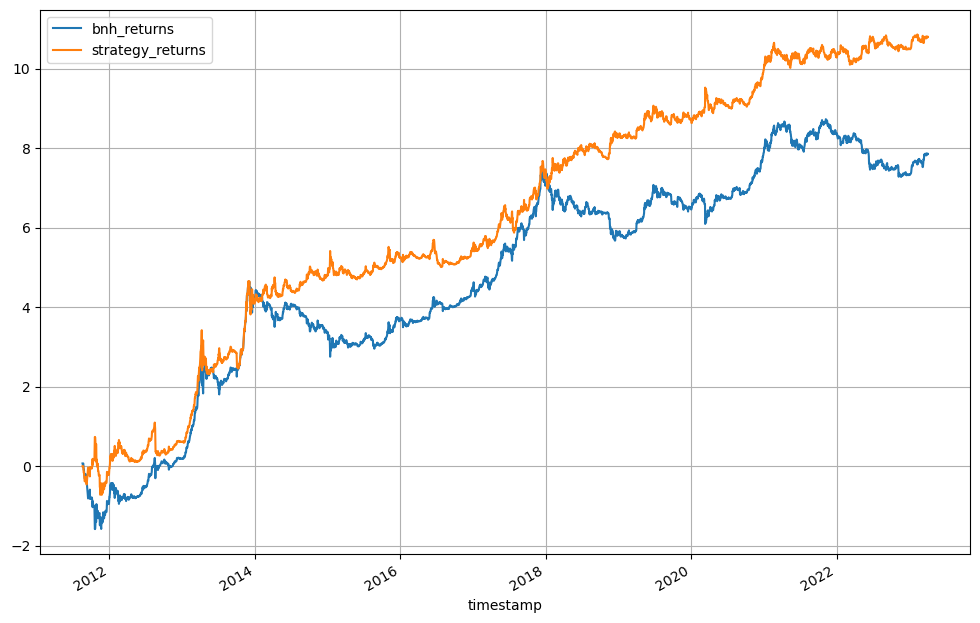

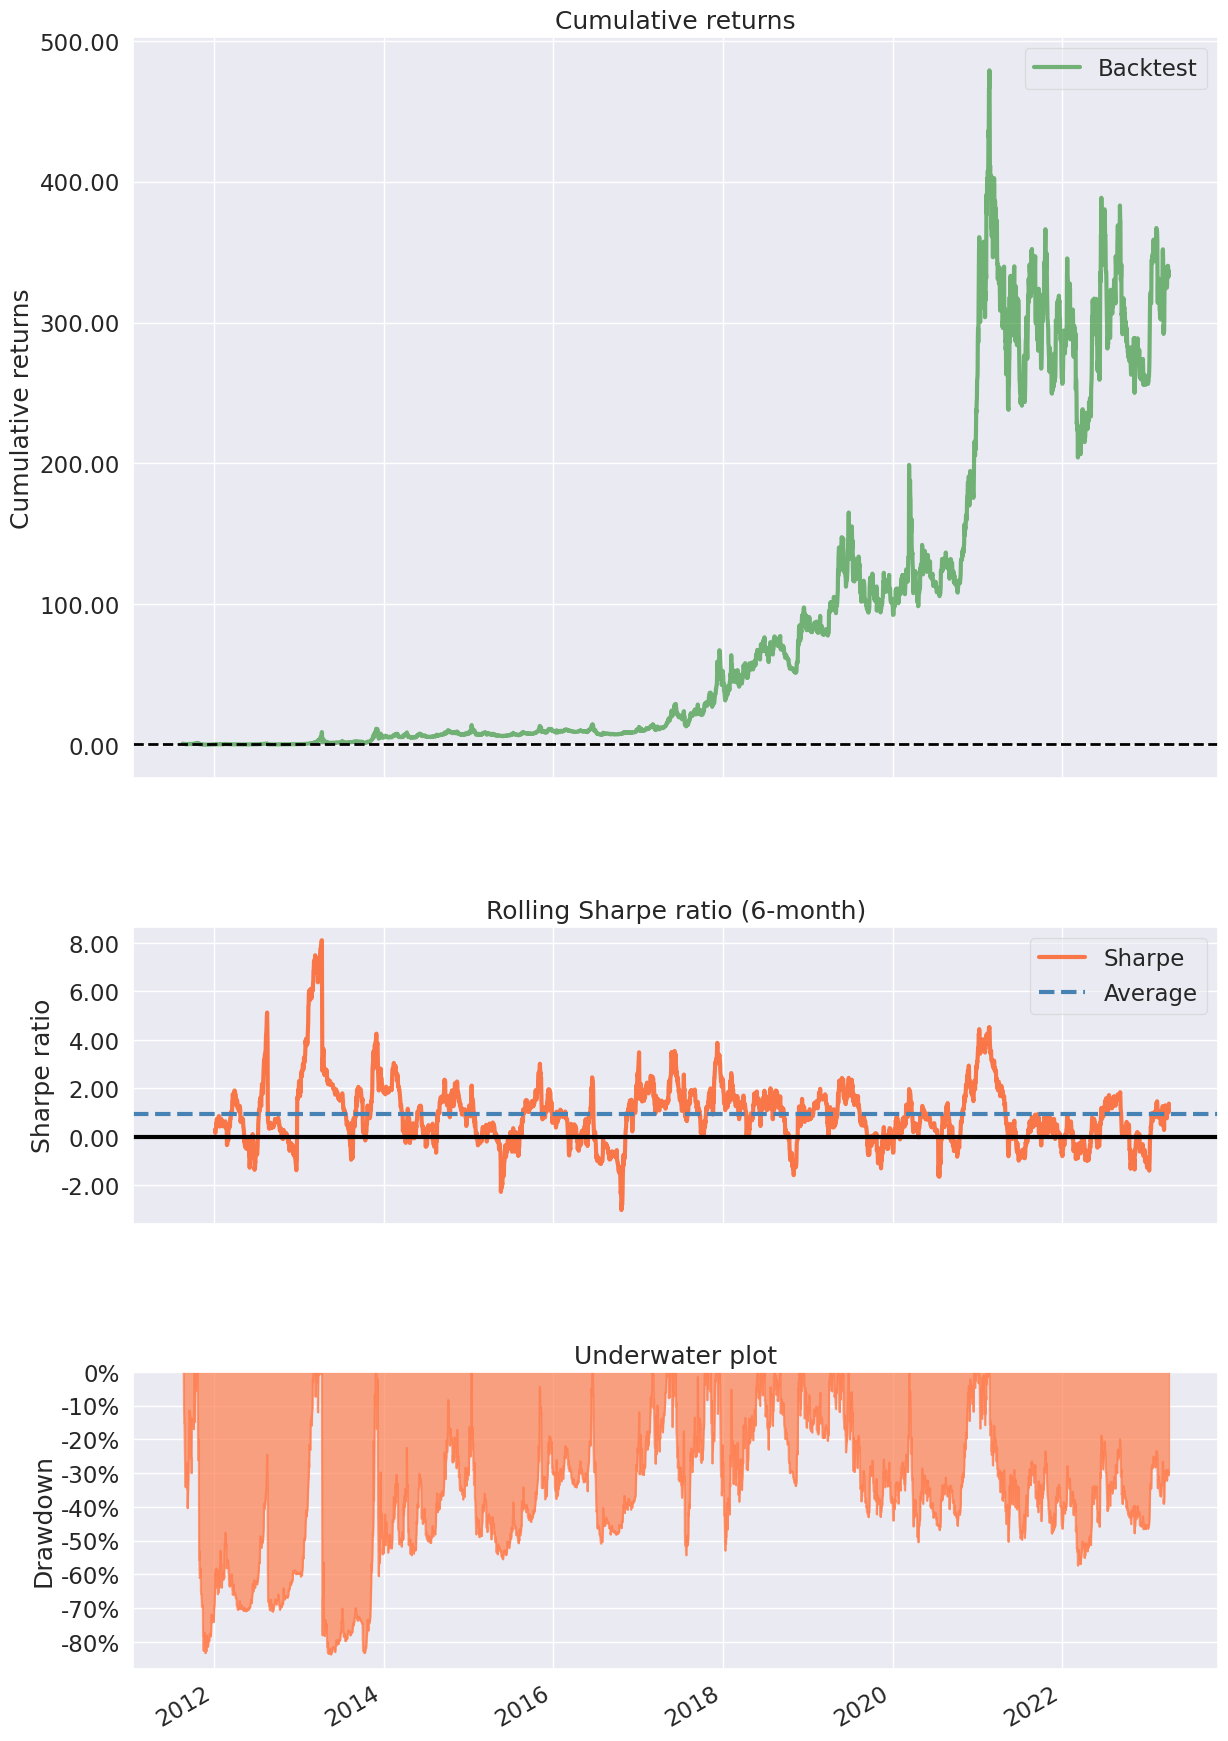

In [4]:
period = 30 #backtested
yukdus = True
sqrt_period = np.sqrt(period)

def borserman_ema(x, y):
    alpha = 2 / (y + 1)
    sum = np.array([alpha * x[0]])
    for i in range(1, len(x)):
        value = alpha * x[i] + (1 - alpha) * sum[i-1]
        sum = np.append(sum, value)
    return sum

close_ema1 = borserman_ema(df['Close'], int(period / 2))
close_ema2 = borserman_ema(df['Close'], period)
metric = borserman_ema(2 * close_ema1 - close_ema2, sqrt_period)

df['metric'] =metric

df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))


df['signal'] = np.where((df['metric'] > df['metric'].shift(1)),1,0)
df['signal'] = np.where( (df['metric'] < df['metric'].shift(1)),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

print(period)
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))
plt.savefig('backtested.png')


pf.create_simple_tear_sheet(df['strategy_returns'].diff())


Start date,2011-08-18
End date,2023-04-05
Total months,201
,Backtest
Annual return,41.4%
Cumulative returns,33565.2%
Annual volatility,75.2%
Sharpe ratio,0.86
Calmar ratio,0.49
Stability,0.95
Max drawdown,-83.7%


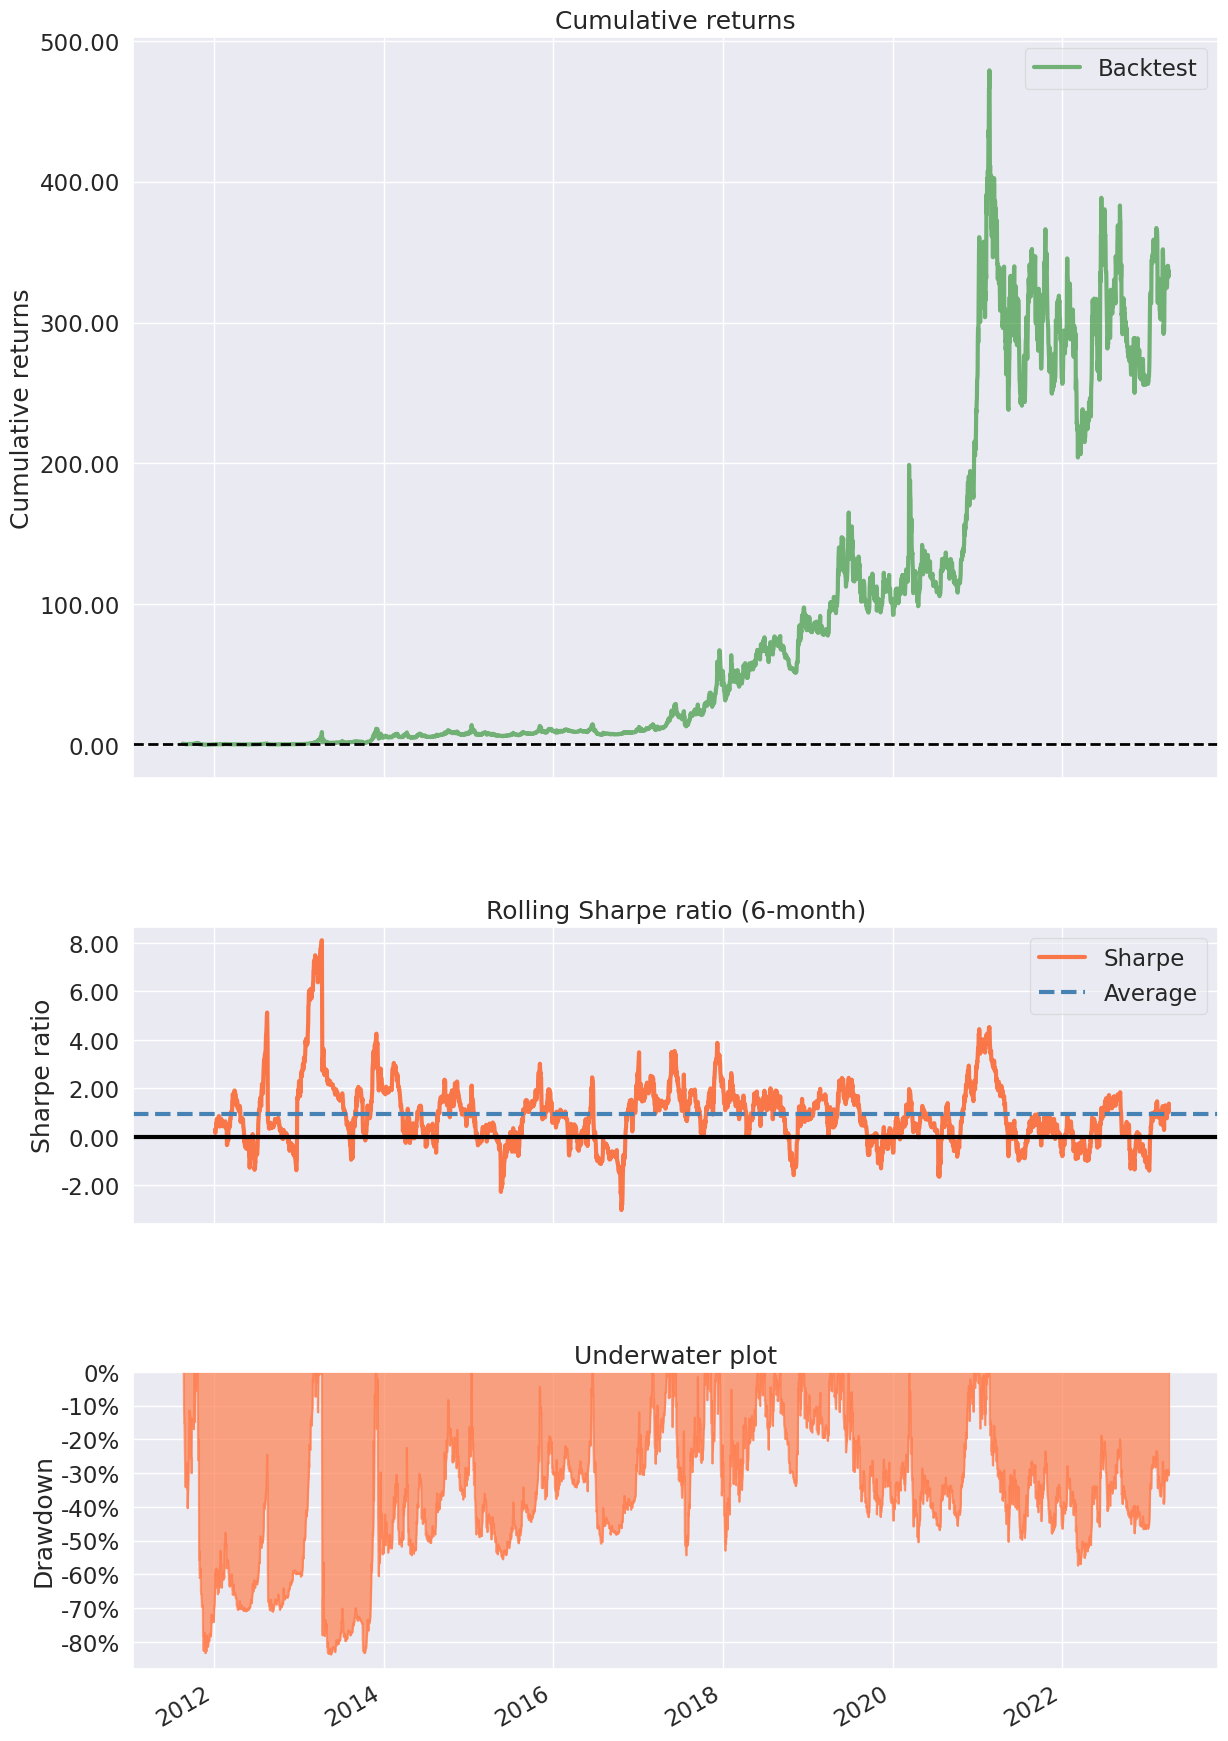

In [5]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())

Last 3months

30
Buy and hold returns: 0.5282001405156772
Strategy returns: 0.2992143369198337


<AxesSubplot:xlabel='timestamp'>

Start date,2023-01-01
End date,2023-04-05
Total months,4
,Backtest
Annual return,99.4%
Cumulative returns,29.7%
Annual volatility,46.0%
Sharpe ratio,1.76
Calmar ratio,4.85
Stability,0.11
Max drawdown,-20.5%


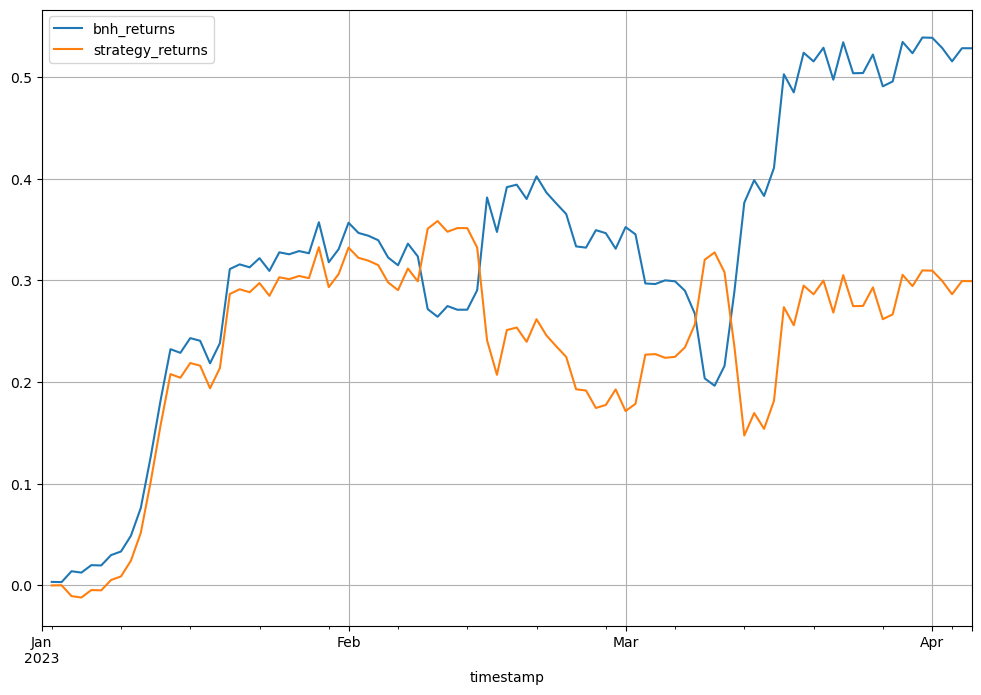

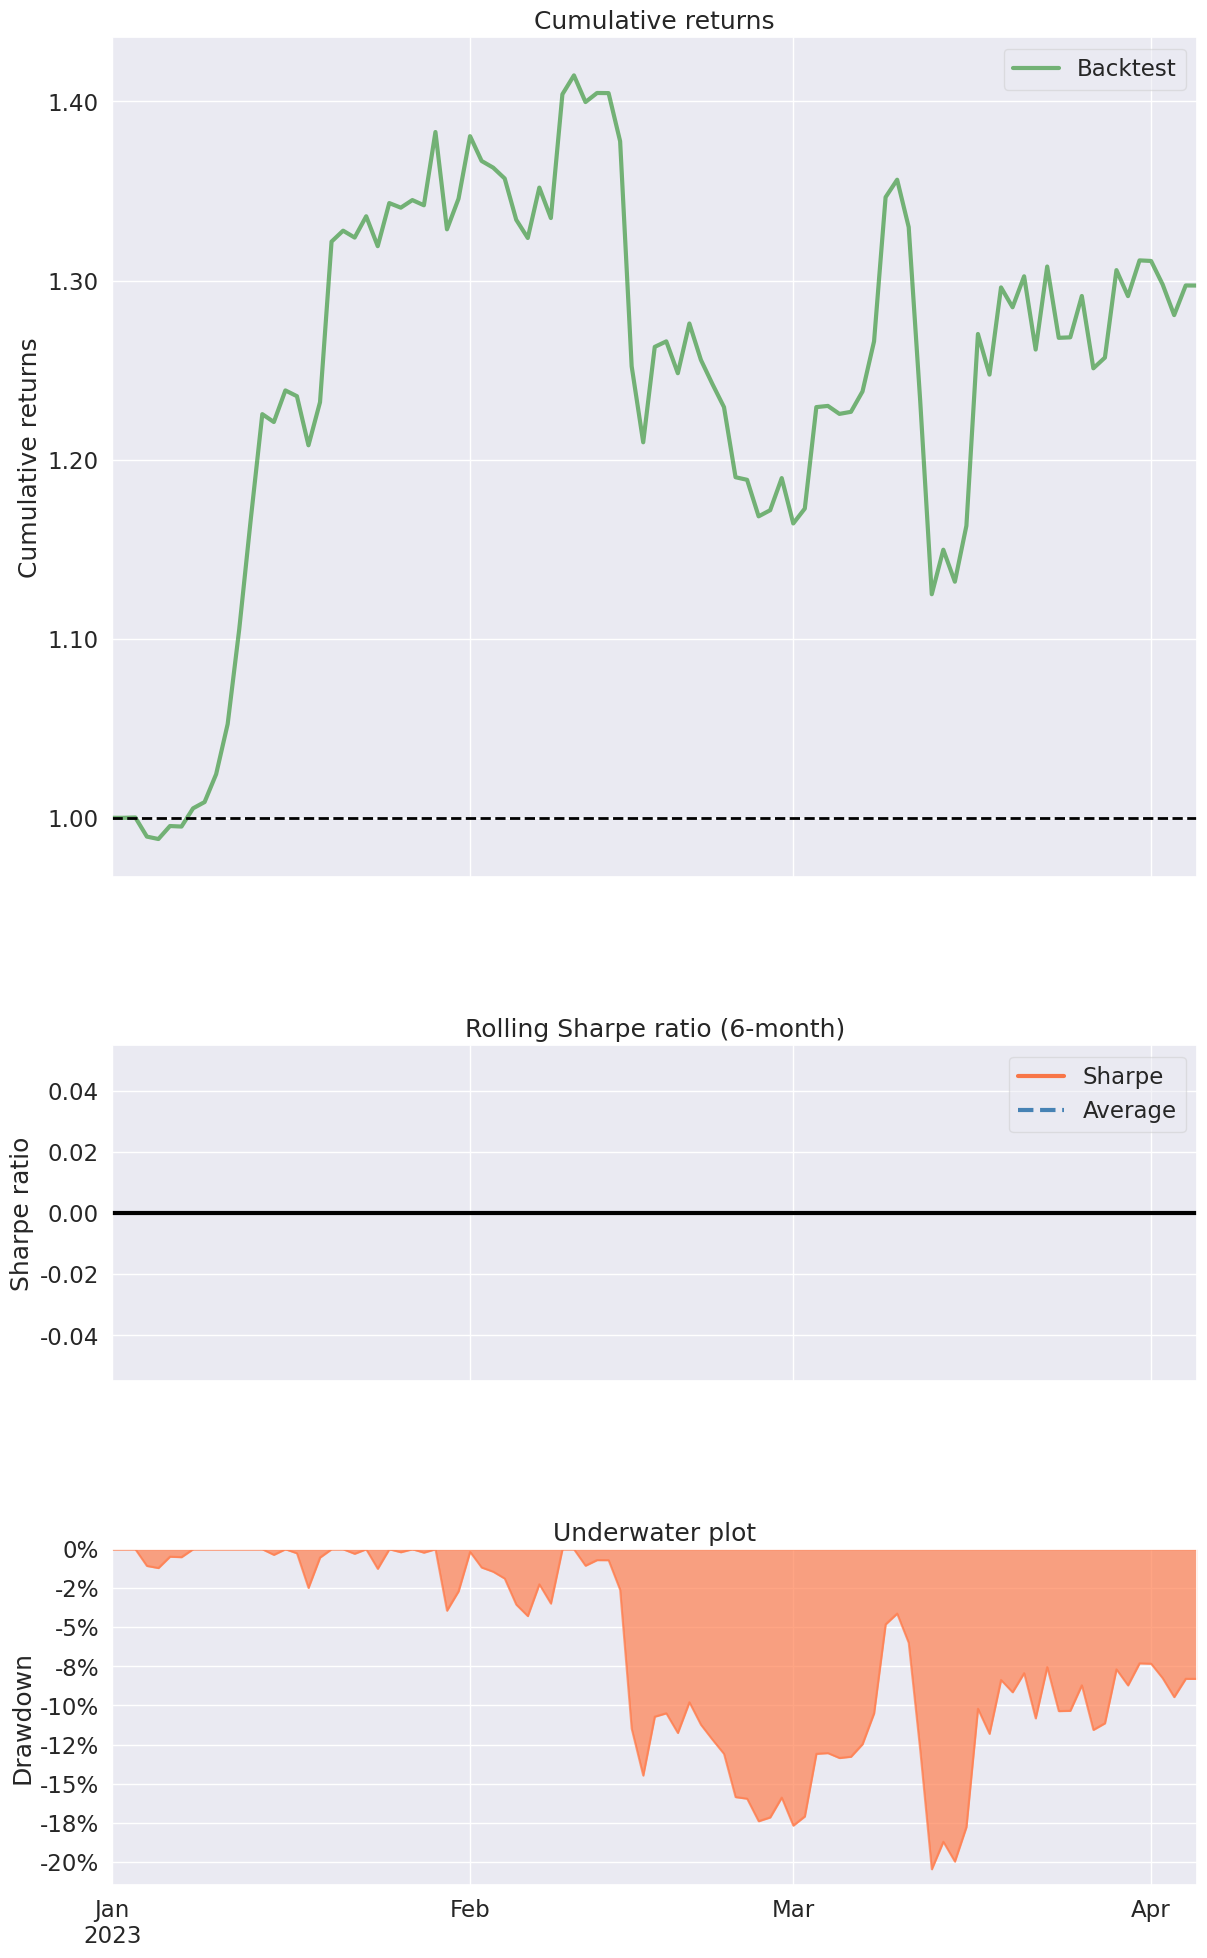

In [6]:
period = 30 #backtested
yukdus = True
sqrt_period = np.sqrt(period)

def borserman_ema(x, y):
    alpha = 2 / (y + 1)
    sum = np.array([alpha * x[0]])
    for i in range(1, len(x)):
        value = alpha * x[i] + (1 - alpha) * sum[i-1]
        sum = np.append(sum, value)
    return sum

close_ema1 = borserman_ema(df['Close'], int(period / 2))
close_ema2 = borserman_ema(df['Close'], period)
metric = borserman_ema(2 * close_ema1 - close_ema2, sqrt_period)

df['metric'] =metric

df = df.loc['2023-01-01':]


df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))


df['signal'] = np.where((df['metric'] > df['metric'].shift(1)),1,0)
df['signal'] = np.where( (df['metric'] < df['metric'].shift(1)),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

print(period)
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))
plt.savefig('backtested.png')


pf.create_simple_tear_sheet(df['strategy_returns'].diff())


In [13]:
df.tail(50)

,Close,Volume,metric,bnh_returns,signal,position,strategy_returns
timestamp,,,,,,,
2023-02-07,23252.0,2758.475644,20125.630123,0.336085,1,1.0,0.272806
2023-02-08,22961.0,1236.371401,20276.229558,0.323491,1,1.0,0.260212
2023-02-09,21802.0,2260.785085,20410.770786,0.271696,1,1.0,0.208417
2023-02-10,21639.0,1503.993238,20530.222669,0.264191,1,1.0,0.200912
2023-02-11,21868.0,699.372553,20638.673432,0.274718,1,1.0,0.211440
2023-02-12,21789.0,1481.785770,20736.939726,0.271099,1,1.0,0.207820
2023-02-13,21790.0,1923.037408,20826.396461,0.271145,1,1.0,0.207866
2023-02-14,22211.0,2032.442807,20911.646741,0.290282,1,1.0,0.227003
2023-02-15,24332.0,2316.238303,21010.352265,0.381486,1,1.0,0.318208
